# Downloading Sentinel-2 Satellite Imagery and Creating a RGB Composite

To download Sentinel-2 satellite images, one needs to install and import the following libraries: rasterio, sentinelsat, geopandas, and folium.

In [69]:
import folium
import os
import numpy as np
import cv2

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
from rasterio import MemoryFile
import rasterio.mask
import fiona

First, we need to define our area of interest. This can be done by reading a GeoJSON file in geopandas. A GeoJSON file stores all the simple geographical features of an area on the map such as points, line string, polygons, etc. A GeoJSOn file for your area of interest can be created using __[geojson.io](http://geojson.io/)__.

In [70]:
aoi = gpd.read_file('bangalore.geojson')
aoi

,geometry
0,"POLYGON ((77.54957 12.95003, 77.62699 12.95003..."


In [71]:
m = folium.Map([12.9716, 77.5946], zoom_start = 11)
folium.GeoJson(aoi).add_to(m)
m

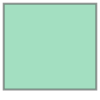

In [72]:
footprint = None
for i in aoi['geometry']:
    footprint = i
    
footprint

In [26]:
user = '' 
password = '' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

products = api.query(footprint,
                     date = ('20220401', '20220501'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0, 15))

In [27]:
len(products)

3

In [28]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending = True)
products_gdf_sorted

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
ebc71778-4c91-4dfb-8c5c-0c6aa91a7134,S2A_MSIL2A_20220418T050701_N0400_R019_T43PGQ_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-04-18T05:07:01.024Z, Instrument: MS...",false,2022-04-18 07:49:03,2022-04-18 05:07:01.024,2022-04-18 05:07:01.024,2022-04-18 10:14:49.083,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20220418T074903_S2022...,S2A_OPER_MSI_L2A_TL_VGS2_20220418T074903_A0356...,S2A_MSIL2A_20220418T050701_N0400_R019_T43PGQ_2...,ebc71778-4c91-4dfb-8c5c-0c6aa91a7134,"MULTIPOLYGON (((77.85047 12.56040, 77.86187 13..."
406a229f-ff3b-45e8-86c9-99cc60e68f8f,S2A_MSIL2A_20220428T050701_N0400_R019_T43PGQ_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-04-28T05:07:01.024Z, Instrument: MS...",false,2022-04-28 09:33:18,2022-04-28 05:07:01.024,2022-04-28 05:07:01.024,2022-04-28 11:01:00.272,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_ATOS_20220428T093318_S2022...,S2A_OPER_MSI_L2A_TL_ATOS_20220428T093318_A0357...,S2A_MSIL2A_20220428T050701_N0400_R019_T43PGQ_2...,406a229f-ff3b-45e8-86c9-99cc60e68f8f,"MULTIPOLYGON (((77.85047 12.56040, 77.86187 13..."
e4dcbb7a-3731-4787-87b6-b4300a8a1d9e,S2B_MSIL2A_20220403T050649_N0400_R019_T43PGQ_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-04-03T05:06:49.024Z, Instrument: MS...",false,2022-04-03 09:12:56,2022-04-03 05:06:49.024,2022-04-03 05:06:49.024,2022-04-03 16:14:45.973,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_VGS4_20220403T091256_S2022...,S2B_OPER_MSI_L2A_TL_VGS4_20220403T091256_A0265...,S2B_MSIL2A_20220403T050649_N0400_R019_T43PGQ_2...,e4dcbb7a-3731-4787-87b6-b4300a8a1d9e,"MULTIPOLYGON (((77.85047 12.56040, 77.86187 13..."


In [33]:
api.download('e4dcbb7a-3731-4787-87b6-b4300a8a1d9e')

MD5 checksumming:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

{'id': 'e4dcbb7a-3731-4787-87b6-b4300a8a1d9e',
 'title': 'S2B_MSIL2A_20220403T050649_N0400_R019_T43PGQ_20220403T091256',
 'size': 1219767219,
 'md5': 'de29a17106b653c355bcbe4c53b7e1b4',
 'date': datetime.datetime(2022, 4, 3, 5, 6, 49, 24000),
 'footprint': 'POLYGON((76.84533677009696 13.216029195555851,76.87818767626851 13.363124624715406,76.91129819191417 13.511722330089931,76.92218164239024 13.560911847005677,77.86186761560747 13.55204944786505,77.85046693601788 12.560404476746363,76.84053428354963 12.569244694574765,76.84533677009696 13.216029195555851))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('e4dcbb7a-3731-4787-87b6-b4300a8a1d9e')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2022, 4, 3, 16, 16, 6, 330000),
 'Ingestion Date': datetime.datetime(2022, 4, 3, 16, 14, 45, 973000),
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('e4dcbb7a-3731-4787-87b6-b4300a8a1d9e')/Products('Quicklook')/$value",
 'path': 'S2B_MSIL2A_202204

In [34]:
api.download('ebc71778-4c91-4dfb-8c5c-0c6aa91a7134')

MD5 checksumming:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

{'id': 'ebc71778-4c91-4dfb-8c5c-0c6aa91a7134',
 'title': 'S2A_MSIL2A_20220418T050701_N0400_R019_T43PGQ_20220418T074903',
 'size': 1234418409,
 'md5': 'a872b0f20fe84053462d537c3b52b6e2',
 'date': datetime.datetime(2022, 4, 18, 5, 7, 1, 24000),
 'footprint': 'POLYGON((76.84544307272667 13.23034571526397,76.86760518761379 13.329720974033354,76.90077429824909 13.47812276590809,76.91908355601505 13.560941065786006,77.86186761560747 13.55204944786505,77.85046693601788 12.560404476746363,76.84053428354963 12.569244694574765,76.84544307272667 13.23034571526397))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('ebc71778-4c91-4dfb-8c5c-0c6aa91a7134')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2022, 4, 18, 10, 15, 14, 955000),
 'Ingestion Date': datetime.datetime(2022, 4, 18, 10, 14, 49, 83000),
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('ebc71778-4c91-4dfb-8c5c-0c6aa91a7134')/Products('Quicklook')/$value",
 'path': 'S2A_MSIL2A_2022041

In [35]:
api.download('406a229f-ff3b-45e8-86c9-99cc60e68f8f')

MD5 checksumming:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

{'id': '406a229f-ff3b-45e8-86c9-99cc60e68f8f',
 'title': 'S2A_MSIL2A_20220428T050701_N0400_R019_T43PGQ_20220428T093318',
 'size': 1231006370,
 'md5': 'd0a86356c8884a33f6b6e695fa610c1b',
 'date': datetime.datetime(2022, 4, 28, 5, 7, 1, 24000),
 'footprint': 'POLYGON((76.84543093326614 13.228710809087637,76.8527833944379 13.261621890088083,76.8859558517184 13.410171927261812,76.91890430019505 13.558889965021464,76.91935863127831 13.560938471486583,77.86186761560747 13.55204944786505,77.85046693601788 12.560404476746363,76.84053428354963 12.569244694574765,76.84543093326614 13.228710809087637))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('406a229f-ff3b-45e8-86c9-99cc60e68f8f')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2022, 4, 28, 11, 2, 11, 905000),
 'Ingestion Date': datetime.datetime(2022, 4, 28, 11, 1, 0, 272000),
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('406a229f-ff3b-45e8-86c9-99cc60e68f8f')/Products('Quicklook')/$

In [89]:
path_to_dir = './data'

path_to_output = './output'
import shutil
if os.path.exists(path_to_output):
     shutil.rmtree(path_to_output)
os.mkdir(path_to_output)

dates_dir = os.listdir(path_to_dir)
for date in dates_dir:
    print(f'Processing image for {date}...')
    files_dir = os.listdir(os.path.join(path_to_dir, date))
    
    blue = rio.open(os.path.join(path_to_dir, date, files_dir[1]))
    green = rio.open(os.path.join(path_to_dir, date, files_dir[2]))
    red = rio.open(os.path.join(path_to_dir, date, files_dir[3]))
    
    with MemoryFile().open(driver='PNG', width = red.width, height = red.height,
                   count = 3, crs = red.crs, transform = red.transform, dtype = red.dtypes[0]) as rgb:
        rgb.write(blue.read(1),3)  
        rgb.write(green.read(1),2) 
        rgb.write(red.read(1),1)
        crs = str(rgb.crs)
        aoi_crs = aoi.to_crs({'init': crs})
        
        out_image, out_transform = rio.mask.mask(rgb, aoi_crs.geometry, crop=True)
        out_meta = rgb.meta.copy()
        out_meta.update({"driver": "PNG",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
        
        with rasterio.open(os.path.join(path_to_output, date+'.PNG'), "w", **out_meta) as dst:
                dst.write(out_image)
        print('Done.')

Processing image for 2022-04-03...


C:\Users\HEEMANSHU\anaconda3\envs\allthingsAI\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Done.
Processing image for 2022-04-18...


C:\Users\HEEMANSHU\anaconda3\envs\allthingsAI\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Done.
Processing image for 2022-04-28...


C:\Users\HEEMANSHU\anaconda3\envs\allthingsAI\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Done.


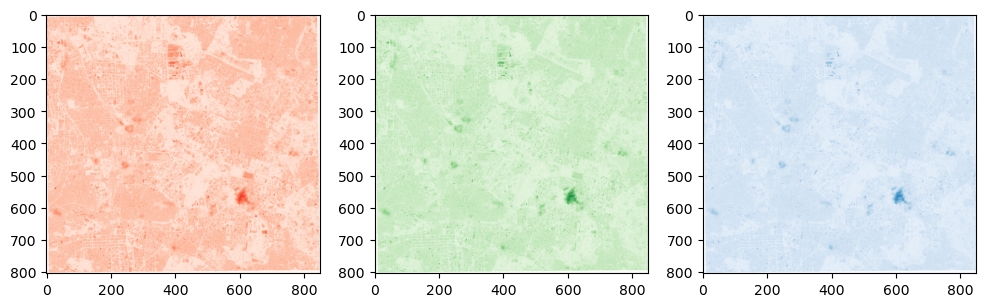

In [74]:
with rio.open('./output/2022-04-28.png') as src:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    show(src.read(1), ax=ax1, cmap = 'Reds')
    show(src.read(2), ax=ax2, cmap = 'Greens')
    show(src.read(3), ax=ax3, cmap = 'Blues')
    src.close()

In [100]:
path_to_corrected = './output/corrected'

import shutil
if os.path.exists(path_to_corrected):
     shutil.rmtree(path_to_corrected)
os.mkdir(path_to_corrected)

for file in os.listdir(path_to_output):
    if file.endswith('.PNG') is True:
            shutil.copyfile(os.path.join(path_to_output, file), os.path.join(path_to_corrected, file))
    else:
        pass

images_dir = os.listdir(path_to_corrected)

In [101]:
for image in images_dir:
        print(f'Processing {image}...')
        b4 = rio.open(os.path.join(path_to_corrected, image)).read(1)
        b3 = rio.open(os.path.join(path_to_corrected, image)).read(2)
        b2 = rio.open(os.path.join(path_to_corrected, image)).read(3)
    
        def img_correction(band):
            alpha = 0.05
            beta = 0
            band = np.clip(alpha*band+beta, 0, 255)
            band_min, band_max = (band.min(), band.max())
            band = ((band-band_min)/((band_max-band_min)))
            return band

        red_cor = img_correction(b4)
        green_cor = img_correction(b3)
        blue_cor = img_correction(b2)
            
        cor_img = np.dstack((red_cor, green_cor, blue_cor))
        rgb_plot = plt.imshow(cor_img, interpolation='lanczos')
        plt.axis('off')
        plt.savefig(os.path.join(path_to_corrected, image), dpi = 200, bbox_inches = 'tight', transparent = True)
        plt.close('all')
        print('Done.')

Processing 2022-04-03.PNG...
Done.
Processing 2022-04-18.PNG...
Done.
Processing 2022-04-28.PNG...
Done.


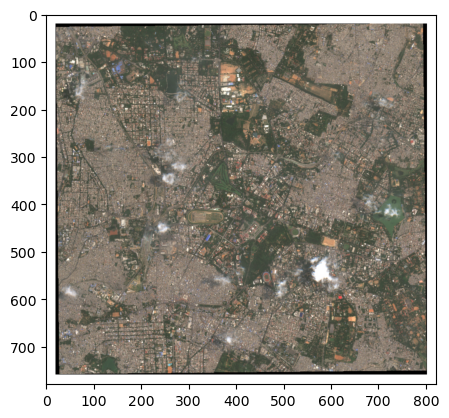

In [112]:
with rio.open(os.path.join(path_to_corrected, '2022-04-28.png')) as src:
    show(src)
    src.close()